# Классификация эмоций.

В данном блокноте продемонстрирован один из многочисленных подходов к семантической классификации текстов при помощи лингвистической модели. Работать будем с данными из [публичного датасета с huggingface](https://huggingface.co/datasets/dair-ai/emotion). EDA проведём на полном наборе данных, а тренироваться и тестироваться на заранее подготовленной разделённой на train, test, val выборке [отсюда](https://huggingface.co/datasets/dair-ai/emotion/tree/main/data).

В качестве baseline в данном задании можно было бы начать с простых легковесных методов, вроде классификации Tfidf или FastText векторов предложений, чтобы потом оценивать прирост качества при использовании более сложных моделей. Но для данного задания в [прикреплёном репозитории](https://github.com/dair-ai/emotion_dataset) предоставлены ссылки на блокнот с базовым пайплайном решения на основе файнтюнинга модели distillroberta-base и публичный лидерборд готовых моделей для данного датасета. 

В задании будем использовать ряд библиотек, которых по умолчанию нет в google-collab, для этого сначала установим их:

* git+https://github.com/PyTorchLightning/lightning-bolts - для упрощения тренировки моделей;
* transformers - для работы с предобученными трансформерами вроде Bert-а;
* tokenizers - для испоьзования быстрых токенизаторов текста вместо более медленных, втроенных в классы моделей из transformers;
* pytorch-lr-finder - для поиска подходящего значения learning_rate при обучении модели;
* optimum[neural-compressor] - для сжатия нейросити.



 # Установка модулей в google-collab

In [6]:
!pip install optimum[neural-compressor]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install git+https://github.com/PyTorchLightning/lightning-bolts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/lightning-bolts to /tmp/pip-req-build-t7ted2rj
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/lightning-bolts /tmp/pip-req-build-t7ted2rj
  Resolved https://github.com/PyTorchLightning/lightning-bolts to commit 3b668ba515e6d9361137983c4f0c86d6c27f9398
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 36.4 MB/s eta 0:00:00
  Created wheel for lightning-bolts: filename=lightning_bolts-0.7.0.dev0-py3-none-any.whl size=329929 sha256=c4660d999896ecec68f2f9e598afc7eb42ccd31d3c15aa354f09c619b8c2af74
  Store

In [3]:
!pip transformers tokenizers accelerate

ERROR: unknown command "neural-compressor"


Note: you need to Restart runtime after running this code segment

In [4]:
%%capture
!git clone https://github.com/davidtvs/pytorch-lr-finder.git && cd pytorch-lr-finder && python setup.py install

# Импорт библиотек

In [11]:
import pathlib
DATA_DIR = pathlib.Path().absolute().parent / 'data'

In [12]:
DATA_DIR 

PosixPath('/Users/zhbannikov/Documents/учёба/Projects/emotion_classification/data')

In [8]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer, BertWordPieceTokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
torch.__version__

'1.13.1+cu117'

# Загрузим данные

In [6]:
## скачаем данные
! wget https://www.dropbox.com/s/lfn1isza8iy1bbc/data.zip

--2023-05-18 03:15:04--  https://www.dropbox.com/s/uc654cxt4sb299x/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/uc654cxt4sb299x/data.zip [following]
--2023-05-18 03:15:07--  https://www.dropbox.com/s/raw/uc654cxt4sb299x/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8576055534a252f508a0553482.dl.dropboxusercontent.com/cd/0/inline/B8R-7LfHoJqnJZY1P1bp4goBQyF3sDjIUSvbAOG6NuUlxUP6F7ALwK8YHE3C3z7W1sRWrqf8iXVRpH38nMP_AzwwJ3BDH3FFbsXpCfPlKlY3qXKU-Nx6Ix_IpumlX_jbwU_Fkoifwl5ia0iMEeF-aG304YMho469gkjdsGJARCSwxA/file# [following]
--2023-05-18 03:15:09--  https://uc8576055534a252f508a0553482.dl.dropboxusercontent.com/cd/0/inline/B8R-7LfHoJqnJZY1P1bp4goBQyF3sDjIUSvbAOG6NuUlxUP6F7ALwK8YHE3C3z7W1sRWrqf8iXVRpH38nMP_AzwwJ3BDH3FFbsXpCfPlKlY3qXKU-Nx6Ix

In [10]:
## разархивируем данные
! unzip data.zip

Archive:  data.zip
  inflating: merged_training.pkl     
  inflating: __MACOSX/._merged_training.pkl  
  inflating: test.jsonl.gz           
  inflating: __MACOSX/._test.jsonl.gz  
  inflating: train_oversampled.jsonl.gz  
  inflating: train.jsonl.gz          
  inflating: __MACOSX/._train.jsonl.gz  
  inflating: validation.jsonl.gz     
  inflating: __MACOSX/._validation.jsonl.gz  


In [12]:
# ## Скачивание моделей, натренированных в данном ноутбуке (раскомментировать, если нужно)
# ! wget https://www.dropbox.com/s/sybzfsxucsozf6i/models.zip

In [ ]:
# ## Разархивирование моделей, натренированных в данном ноутбуке (раскомментировать, если нужно)
# ! unzip models.zip

# Проведём EDA

In [ ]:
import pickle

def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [ ]:
data = load_from_pickle(directory=DATA_DIR / "merged_training.pkl")

In [ ]:
data.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


<AxesSubplot:>

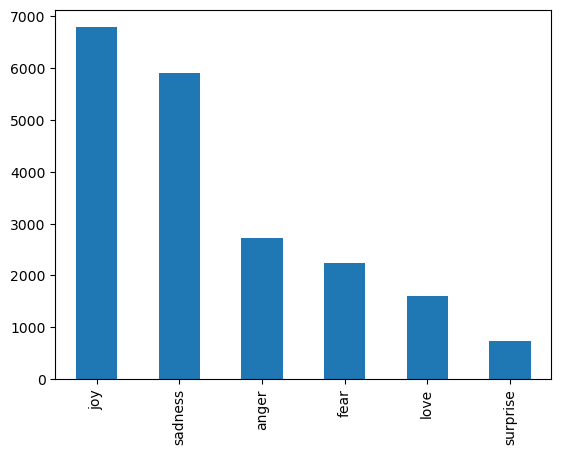

In [ ]:
# Посмотрим на распределение данных по классам
data = data.sample(n=20000, random_state = 42)
data.emotions.value_counts().plot.bar()

На глаз заметен дисбаланс классов, поэтому тренировочную выборку стоит предобработать. Проведём для этого oversampling (досемплируем дубликатов для недостающих классов).

In [ ]:
data.head()

,text,emotions
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


In [ ]:
## Выведем все классы в нашей задаче
data.emotions.unique()

array(['fear', 'sadness', 'love', 'joy', 'surprise', 'anger'],
      dtype=object)

# Подготовим данные для дальнейшей обработки

In [3]:
import pandas as pd

In [4]:
## индексы классов
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

int_to_label = dict([(v, k) for k,v in label2int.items()])

emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]

In [53]:
train_path = 'train.jsonl.gz'
test_path = 'test.jsonl.gz'
val_path = 'validation.jsonl.gz'

In [54]:
train_dataset = pd.read_json(DATA_DIR / train_path, lines=True, compression='gzip')
val_dataset = pd.read_json(DATA_DIR / test_path, lines=True, compression='gzip')
test_dataset = pd.read_json(DATA_DIR / val_path, lines=True, compression='gzip')

In [55]:
train_dataset

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [56]:
# Посмотрим сколько экземпляров из самого крупного класса
train_dataset.label.value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

насемплируем 5362 экземпляра каждого класса из изначального датасета

In [57]:
sample_func = lambda x: x.sample(5362, replace=True)

In [58]:
train_dataset = train_dataset.groupby('label').apply(sample_func)
train_dataset.index = list(range(32172))
train_dataset = train_dataset.sample(frac = 1).reset_index(drop = True)

In [60]:
train_path = 'train_oversampled.jsonl.gz'
train_dataset.to_json(DATA_DIR / train_path, orient = 'records', lines=True, compression='gzip')

In [61]:
train_dataset = pd.read_json(DATA_DIR / train_path, lines=True, compression='gzip')

In [62]:
train_dataset

,text,label
0,i feel myself caring and wondering more than them,2
1,i didn t feel like getting shaken down by the ...,4
2,i just kind of feel blank about the whole thing,0
3,i did on weekends was sleep and feel bitter ab...,3
4,i didn t feel as terrified or as nervous as i ...,4
...,...,...
32167,i am feeling happy thank you,1
32168,i feel your loving presence everywhere,2
32169,i feel nostalgic to travel away from my countr...,2
32170,im being silly but i feel like a terrible mom ...,0


<AxesSubplot:>

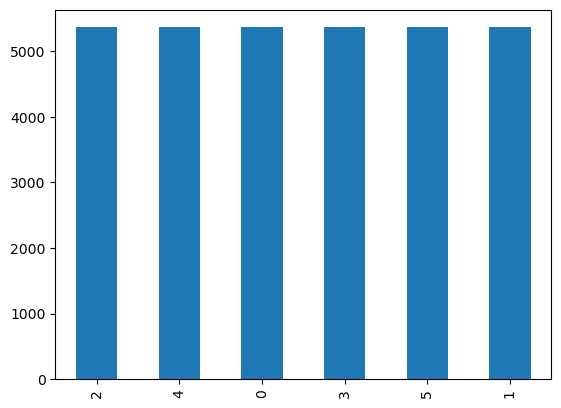

In [63]:
train_dataset.label.value_counts().plot.bar()

# Приведём загрузку данных из датасетов к стандартизированному виду

При использовании pytorch загружать данные бачами удобно с использованием наследования от базовых классов Dataset и DataLoader. Для создания класса Dataset, который будет хранить данные в нужном формате и передовать их DataLoader-у при загрузке необходимо реализовать методы __init__, __getitem__, __len__.

In [14]:
class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.label_column = "label"
        self.data = pd.read_json(path, lines=True, compression='gzip')
        self.data[self.class_column] = self.data[self.label_column].apply(lambda x: int_to_label[x])

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], self.data.loc[idx, self.label_column]

    def __len__(self):
        return self.data.shape[0]

In [15]:
ds = EmoDataset(DATA_DIR / train_path)
ds[19]

('i now feel compromised and skeptical of the value of every unit of work i put in',
 4)

# Загрузка предобученных моделей

В качестве лингвистической модели будем использовать DistilRoBERTa-base, как и в примере. RoBERT - модернизированная версия общеизвестного трансформера BERT, которая на большинстве бенчмарков показывает более высокие результаты. DistilRoBERTa - её дестиллированная версия (количество параметров снижено с 125M до 85M). Large версия модели вероятно показала бы более высокие результаты, но начнём с base версии поменьше и сэкономим время и ресурсы на обучении.

Также после дообучения собственной модели, сравним её по качеству с [первой моделью](https://huggingface.co/Vasanth/bert-base-uncased-finetuned-emotion) на публичном лидерборде. Она основана на модели bert-base, поэтому последующие классы-обертки будем писать под особенности DistilRoBERTa-base и bert-base поотдельности

## Загрузим токенизаторы обеих моделей:

Модели BERT и RoBERTa используют различные токенизаторы BertWordPieceTokenizer и ByteLevelBPETokenizer соответственно, поэтому работать с ними придётся поотдельности. 

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
tokenizer_leader = AutoTokenizer.from_pretrained("Vasanth/bert-base-uncased-finetuned-emotion")

Для файнтюнинга загрузим предобученную модель distilroberta-base и оставим только базовую модель без последних слоёв (вместо них мы позже поставим свой классификатор)

In [13]:
model = AutoModelWithLMHead.from_pretrained('distilroberta-base')
base_model = model.base_model

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1352: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


## Построим классификатор текстов на основе предобученной модели

Будем ипользовать ["Mish"](https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py) функцию активации, как и в оригинальном обучении.

In [17]:
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

напишем класс для "файнтюнинга" 

In [18]:
# Файнтюинг модели
class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
    
        return self.classifier(hidden_states[0][:, 0, :])

# обертка над готовым классификатором для приведения к тому же виду
class EmoReadyModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, input_, *args):
        X, attention_mask = input_
        outputs = self.base_model(X, attention_mask=attention_mask)
    
        return outputs.logits

## Протестируем работу модели до обучения на рандомном тексте

In [17]:
classifier = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, 6)

In [18]:
text = "Elvis is the king of rock!"
enc = tokenizer.encode_plus(text)
enc.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
X = torch.tensor(enc["input_ids"]).unsqueeze(0).to('cpu')
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).to('cpu')

In [20]:
classifier((X, attn))

tensor([[ 0.0097,  0.0412,  0.1880, -0.0821, -0.0005, -0.0242]],
       grad_fn=<AddmmBackward0>)

модель возвращает из выходного слоя с классификатором 6 значений (тк имеем 6 классов), тут всё по плану

## Заменим встроенные токенизаторы их более быстрой реализацией из https://github.com/huggingface/tokenizers

In [19]:
def save_tokenizer(tokenizer, name):
    try:
        os.mkdir(name)
    except Exception as e:
        print(e)
        pass
    tokenizer.save_pretrained(name)

In [20]:
save_tokenizer(tokenizer, "tokenizer")
save_tokenizer(tokenizer_leader, "tokenizer_leader")

In [21]:
!ls tokenizer

merges.txt		 tokenizer_config.json	vocab.json
special_tokens_map.json  tokenizer.json


Реализуем класс (сollateFN) для предварительной обработки данных в DataLoader на основе быстрых токенизаторов. Это нужно, чтобы DataLoader на выходе отдавал бачи токенизированных предложений.

In [22]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        self.tokenizer = None

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels


# Тут используется токенизатор ByteLevelBPE, как в  RoBERTa
class ByteLevelBPETokenizersCollateFn(TokenizersCollateFn):
    def __init__(self, max_tokens=512):

        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t


# Тут используется токенизатор BertWordPiece, как в BERT
class  BertWordPieceTokenizersCollateFn(TokenizersCollateFn):
    def __init__(self, max_tokens=512):

        t =  BertWordPieceTokenizer(
            "tokenizer_leader/vocab.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("[SEP]", t.token_to_id("[SEP]")),
            ("[CLS]", t.token_to_id("[CLS]")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(length=max_tokens, pad_id=t.token_to_id("[PAD]"))
        self.tokenizer = t





## Приступим к обучению

Обучение будем проводить с использованием [PyTorchLightning](https://www.pytorchlightning.ai/). Для этого напишем тренировочный модуль, унаследованный от pl.LightningModule. В таком модуле необходимо реализовать несколько [обязательных методов](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html)

In [23]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams, base_model = "distilroberta-base"):
        super().__init__()
        self.model = None
        self.loss = nn.CrossEntropyLoss()
        #self.hparams = hparams
        self.hparams.update(vars(hparams))

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def loade_model(self, path, base_model = "distilroberta-base"):
        self.model = EmoModel(AutoModelWithLMHead.from_pretrained(base_model).base_model, len(emotions))
        self.model.load_state_dict(torch.load(path))


        
        
# Тренировочный модуль для файнтюнинга модели EmoModel
class FinetuneTrainingModule(TrainingModule):
    def __init__(self, hparams, base_model = "distilroberta-base"):
        super().__init__(hparams, base_model = base_model)
        self.model = EmoModel(AutoModelWithLMHead.from_pretrained(base_model).base_model, len(emotions))

    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn= ByteLevelBPETokenizersCollateFn()
        )


# Тренировочный модуль для работы с готовой моделью EmoReadyModel
class ReadyTrainingModule(TrainingModule):
    def __init__(self, hparams, base_model = None):
        super().__init__(hparams, base_model = base_model)
        self.model = EmoReadyModel(base_model)

    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn= BertWordPieceTokenizersCollateFn()
        )

    

## Найдём подходящий для тренировки learning rate

Для поиска подходящего learning rate используем [следующий модуль](https://github.com/davidtvs/pytorch-lr-finder). Основная идея заключается в том, чтобы запустить предварительную тренировку нейросети с каждым шагом увеличивая lr и найти такой, когда лосс начнёт монотонно увеличиваться. В обучении к pytorch-lr-finder советуется взять значение lr на половине пути до минимума.

In [19]:
# hparams_tmp = Namespace(
#     train_path=train_path,
#     val_path=val_path,
#     test_path=test_path,
#     batch_size=16,
#     warmup_steps=100,
#     epochs=1,
#     lr=1e-4,
#     accumulate_grad_batches=1,
# )
# module = FinetuneTrainingModule(hparams_tmp, base_model = "distilroberta-base") #base_model = "distilroberta-base"

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.13E-03


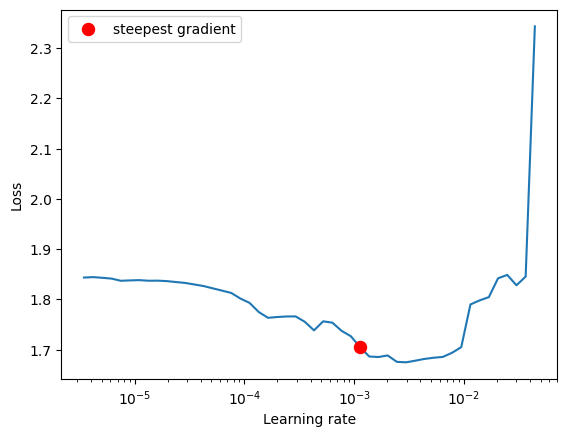

In [26]:
from torch_lr_finder import LRFinder

lr=0.1 ## Верхняя граница 
lr_start = 5e-7 ## Нижняя граница

hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)
module = FinetuneTrainingModule(hparams_tmp, base_model = "distilroberta-base") #base_model = "distilroberta-base"
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(module.parameters(), lr=lr_start) ## lower bound LR
lr_finder = LRFinder(module, optimizer, criterion, device="cuda")
lr_finder.range_test(module.train_dataloader(), end_lr=100, num_iter=100, accumulation_steps=hparams_tmp.accumulate_grad_batches)
lr_finder.plot()
lr_finder.reset()

In [38]:
lr = 1e-4 
lr

0.0001

LR suggestion: steepest gradient
Suggested LR: 1.13E-03


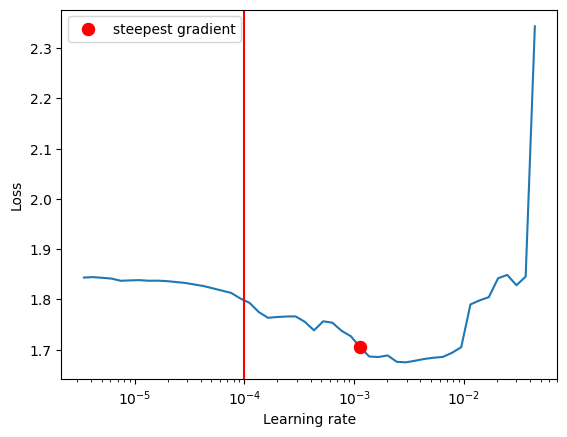

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.001129591765336144)

In [39]:
lr_finder.plot(show_lr=lr)

## Training the Emotion Classifier

In [59]:
## сбор мусора
import gc; gc.collect()
torch.cuda.empty_cache()

In [43]:
# Тренировка нейросети
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)
module = FinetuneTrainingModule(hparams, base_model = "distilroberta-base")


trainer = pl.Trainer(accelerator="auto", max_epochs=hparams.epochs, 
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1352: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.Ad

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [50]:
_ = module.model.to("cuda")

## Оценим качество полученной модели

При оценке будем ориентироваться на метрику f1, тк она одновременно отражает в себе и точность и полноту предсказаний модели. Для большей наглядности и подробного анализа при оценке будем также выводить recall и precision потдельности 

In [25]:
import time

# Функция для оценки качества предсказаний
def evaluate_model(module, device = 'cpu', iters = None, log = False):
    with torch.no_grad():
        progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
        module.eval()
        true_y, pred_y = [], []
        t0 = time.time()
        for i, batch_ in enumerate(module.test_dataloader()):
            (X, attn), y = batch_
            if log:
                print(f"Шаг {i}, время {int(time.time() - t0)} секунд от старта" )
            if device == 'cpu':
                batch = (X, attn)
            elif device == 'cuda':
                batch = (X.cuda(), attn.cuda())
            print(progress[i % len(progress)], end="\r")
            y_pred = torch.argmax(module(batch), dim=1)
            true_y.extend(y.cpu())
            pred_y.extend(y_pred.cpu())
            if iters:
                if i>iters:
                    break
    print("\n" + "_" * 80)
    print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=len(emotions)))

In [52]:
evaluate_model(module, device = 'cuda')


________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.969203  0.920826  0.944395       581
         joy   0.938218  0.939568  0.938893       695
        love   0.791209  0.905660  0.844575       159
       anger   0.895833  0.938182  0.916519       275
        fear   0.902326  0.866071  0.883827       224
    surprise   0.686567  0.696970  0.691729        66

    accuracy                       0.915000      2000
   macro avg   0.863893  0.877880  0.869990      2000
weighted avg   0.917380  0.915000  0.915593      2000



Сохраним дообученную модель

In [48]:
module.save_model(path = 'distilroberta-base_model.pickle')

Загрузим модель

In [49]:
module.loade_model(path = 'distilroberta-base_model.pickle', base_model = "distilroberta-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1352: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


## Сравним результаты с лидирующей из предобученных на данном датасете моделей

In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer_leader = AutoTokenizer.from_pretrained("Vasanth/bert-base-uncased-finetuned-emotion")
model_leader = AutoModelForSequenceClassification.from_pretrained("Vasanth/bert-base-uncased-finetuned-emotion")

In [27]:
leader_module = ReadyTrainingModule(hparams, base_model = model_leader)

In [28]:
_ = leader_module.model.to("cuda")

In [56]:
evaluate_model(leader_module, device = 'cuda')


________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.963351  0.950086  0.956672       581
         joy   0.955490  0.926619  0.940833       695
        love   0.760638  0.899371  0.824207       159
       anger   0.925926  0.909091  0.917431       275
        fear   0.867220  0.933036  0.898925       224
    surprise   0.814815  0.666667  0.733333        66

    accuracy                       0.921000      2000
   macro avg   0.881240  0.880812  0.878567      2000
weighted avg   0.923689  0.921000  0.921404      2000



# Заметно, что по результатам модель с лидерборда "из коробки" демонстрирует соизмеримое качество. Попробуем дообучить её те же способом.

In [77]:
## Дополнительная очистка видеокарт от мусора

# from numba import cuda
# # all of your code and execution
# cuda.select_device(0)
# cuda.close()


# device = cuda.get_current_device() 
# device.reset()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.32E-07


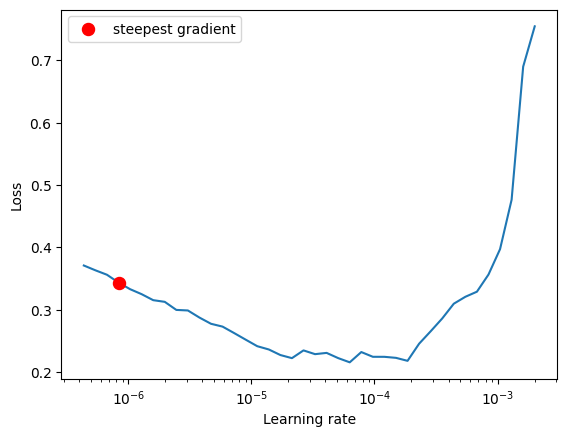

In [30]:
lr=0.1
from torch_lr_finder import LRFinder
hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(leader_module.parameters(), lr=5e-8) ## lower bound LR
lr_finder = LRFinder(leader_module, optimizer, criterion, device="cuda")
lr_finder.range_test(leader_module.train_dataloader(), end_lr=100, num_iter=100, accumulation_steps=hparams_tmp.accumulate_grad_batches)
lr_finder.plot()
lr_finder.reset()

Заметим, что оптимальный lr для данной модели получился на 2 порядка меньше. В первую очередь это связано с тем, что модель уже предобучена на данное задание, соответственно, чтобы увеличить качество при дообучении нужно взять меньший lr

In [31]:
# дообучим модель лидер
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=1e-6,
    accumulate_grad_batches=1,
)

## train roughly for about 10-15 minutes with GPU enabled.
trainer = pl.Trainer(accelerator="auto", max_epochs=hparams.epochs, 
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(leader_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | EmoReadyModel    | 109 M 
-------------------------------------------
109 M     Trainable params
0      

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [33]:
_ = leader_module.model.to("cuda")

In [35]:
evaluate_model(leader_module, device = 'cuda')


________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.979058  0.965577  0.972270       581
         joy   0.956647  0.952518  0.954578       695
        love   0.852564  0.836478  0.844444       159
       anger   0.933086  0.912727  0.922794       275
        fear   0.877193  0.892857  0.884956       224
    surprise   0.670732  0.833333  0.743243        66

    accuracy                       0.931000      2000
   macro avg   0.878213  0.898915  0.887048      2000
weighted avg   0.933309  0.931000  0.931820      2000



После дообучения качество ещё немного поднялось. Сохраним окончательную версию

In [32]:
leader_module.save_model(path = 'bert-base_uncased_model.pickle')

# Сожмём модель в размере

К наиболее популярными методами сжатия/уменьшения нейросетей можно отнести квантизацию, прунинг и дистилляцию знаний. 

В процессе квантизации матрицы весов нейросети бинаризиются с заданным размером шага. Таким образом веса нейросети из изначального формата с плавающей точкой float32 приводятся к целочисленному int4/8/16. Во множестве источников экспериментально показано, что в большинстве случаев при минимальной квантизации с float32 до int16 качество не меняется в заметных масштабах, при нейросеть сжимается в 2 раза. во многих случаях может получиться и квантизация до int8 без сильной потери качества, тут нужно экспериментировать.

Прунинг в свою очередь сжимает нейросеть за счет устранения части малозначимых параметров в предобученной модели. Обычно данным методом выбрасывают не более половины весов нейросети. 

Дистилляция знаний представляет из себя обучение более легковесной модели "ученика" на основе выходов с одного из последних слоёв более крупной модели "учителя". Принято считать, что результаты получаются неплохими при сокращении числа параметров не более, чем в 2 раза.

Квантизация - наиболее простой и очевидный способ из описанных, который позволяет практически безболененно сжать модель в размере. К тому же в отлчие от двух других чаще позволяет сильнее сжать модель (в 4 раза с float32 до int8). Более того, базовая предобученная модель, на основе которой был построен класификатор эмоций уже является дистиллированной верией RoBerta-base, для дальнейшей дистилляции пришлось бы в качестве ученика брать нейросеть с сильно отличающейся архитектурой. Вероятно качество бы снизилоь в таком случае сильнее.

Основным минусом квантизации является недоступность инференса на gpu для сжатой модели (по крайней мере это так при использовании известных мне модулей). Таким образом сжатую модель можно будет запустить только на cpu. При этом для некоторых задач это не проблема. Например, если подобная нейросеть будет испоьзоваться в мобильном приложении, где нет возможности использовать gpu. Или в задаче с оффлайн расчётом, где скорость работы не так критична.

Далее сжимать будем дообученную модель с лидерборда, тк она показала наилучшие результаты из представленных.

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer_leader = AutoTokenizer.from_pretrained("Vasanth/bert-base-uncased-finetuned-emotion")
model_leader = AutoModelForSequenceClassification.from_pretrained("Vasanth/bert-base-uncased-finetuned-emotion")

Загрузим дообученную модель с лидерборда

In [43]:
best_model_parent = EmoReadyModel(AutoModelForSequenceClassification.from_pretrained("Vasanth/bert-base-uncased-finetuned-emotion"))
best_model_parent.load_state_dict(torch.load('bert-base_uncased_model-2.pickle'))

<All keys matched successfully>

In [45]:
model_best = best_model_parent.base_model

In [46]:
lr=1e-4 ## uper bound LR
# from torch_lr_finder import LRFinder
hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)
module_best = ReadyTrainingModule(hparams_tmp, base_model = model_best)
# q_module = FinetuneTrainingModule(hparams_tmp, base_model = "distilroberta-base")

In [40]:
_ = module_best.model.to("cuda")

In [41]:
%%time
evaluate_model(module_best, device = 'cuda')


________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.979058  0.965577  0.972270       581
         joy   0.956647  0.952518  0.954578       695
        love   0.852564  0.836478  0.844444       159
       anger   0.933086  0.912727  0.922794       275
        fear   0.877193  0.892857  0.884956       224
    surprise   0.670732  0.833333  0.743243        66

    accuracy                       0.931000      2000
   macro avg   0.878213  0.898915  0.887048      2000
weighted avg   0.933309  0.931000  0.931820      2000

CPU times: user 1min 8s, sys: 158 ms, total: 1min 8s
Wall time: 1min 12s


In [42]:
torch.save(model_leader.state_dict(), 'before_quantization_model.bin')

### Приступим к квантизации модели

In [48]:
## Динамическая квантизация

from transformers import AutoModelForQuestionAnswering
from neural_compressor.config import PostTrainingQuantConfig
from optimum.intel import INCQuantizer
# 


save_dir = "dynamic_quantization"

# зададим стандартную конфигурацию
quantization_config = PostTrainingQuantConfig(approach="dynamic")
quantizer = INCQuantizer.from_pretrained(model_best)
# Применим динамическое квантование модели и сохраним результаты
quantized = quantizer.quantize(quantization_config=quantization_config, save_directory=save_dir)

2023-05-16 21:12:57 [WARNING] Force convert framework model to neural_compressor model.
2023-05-16 21:12:57 [INFO] Start auto tuning.
2023-05-16 21:13:00 [INFO] Pass query framework capability elapsed time: 2923.94 ms
2023-05-16 21:13:00 [INFO] Adaptor has 1 recipes.
2023-05-16 21:13:00 [INFO] 0 recipes specified by user.
2023-05-16 21:13:00 [INFO] 0 recipes require future tuning.
2023-05-16 21:13:00 [INFO] *** Initialize auto tuning
2023-05-16 21:13:00 [INFO] Get FP32 model baseline.
2023-05-16 21:13:00 [INFO] Save tuning history to /content/nc_workspace/2023-05-16_17-51-51/./history.snapshot.
2023-05-16 21:13:00 [INFO] FP32 baseline is: [Accuracy: 1.0000, Duration (seconds): 0.0000]
2023-05-16 21:13:00 [INFO] Quantize the model with default config.
2023-05-16 21:13:01 [INFO] Fx trace of the entire model failed, We will conduct auto quantization
2023-05-16 21:13:08 [INFO] |Mixed Precision Statistics|
2023-05-16 21:13:08 [INFO] +-----------+-------+------+
2023-05-16 21:13:08 [INFO] | 

In [49]:
# Загрузим квантизированную модель 
from optimum.intel.neural_compressor import INCModelForSequenceClassification
quantized_model = INCModelForSequenceClassification.from_pretrained(PROJ_DIR / 'dynamic_quantization')
quantized_model.eval()

loading configuration file /content/dynamic_quantization/inc_config.json
INCConfig {
  "distillation": {},
  "neural_compressor_version": "2.1.1",
  "optimum_version": "1.8.5",
  "pruning": {},
  "quantization": {
    "dataset_num_samples": null,
    "is_static": false
  },
  "save_onnx_model": false,
  "torch_version": "1.13.1",
  "transformers_version": "4.29.1"
}



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): GraphModule(
        (module): QuantizedEmbedding(num_embeddings=30522, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
      )
      (position_embeddings): GraphModule(
        (module): QuantizedEmbedding(num_embeddings=512, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
      )
      (token_type_embeddings): GraphModule(
        (module): QuantizedEmbedding(num_embeddings=2, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
      )
      (LayerNorm): GraphModule(
        (module): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
             

In [ ]:
# quantized_model.to("cpu")

In [50]:
q_module = ReadyTrainingModule(hparams, base_model = quantized_model)

In [51]:
%%time
evaluate_model(q_module, device = 'cpu', iters = 125, log = True)

Шаг 0, время 0 секунд от старта
Шаг 1, время 46 секунд от старта
Шаг 2, время 87 секунд от старта
Шаг 3, время 125 секунд от старта
Шаг 4, время 161 секунд от старта
Шаг 5, время 198 секунд от старта
Шаг 6, время 235 секунд от старта
Шаг 7, время 270 секунд от старта
Шаг 8, время 306 секунд от старта
Шаг 9, время 341 секунд от старта
Шаг 10, время 378 секунд от старта
Шаг 11, время 416 секунд от старта
Шаг 12, время 452 секунд от старта
Шаг 13, время 488 секунд от старта
Шаг 14, время 523 секунд от старта
Шаг 15, время 558 секунд от старта
Шаг 16, время 592 секунд от старта
Шаг 17, время 628 секунд от старта
Шаг 18, время 663 секунд от старта
Шаг 19, время 705 секунд от старта
Шаг 20, время 742 секунд от старта
Шаг 21, время 778 секунд от старта
Шаг 22, время 814 секунд от старта
Шаг 23, время 850 секунд от старта
Шаг 24, время 886 секунд от старта
Шаг 25, время 922 секунд от старта
Шаг 26, время 957 секунд от старта
Шаг 27, время 991 секунд от старта
Шаг 28, время 1027 секунд от старт

# Результаты

Сравним результаты:

________________________________________________________________________________

Новая модель:
              
               precision    recall  f1-score   support

     sadness     0.969203  0.920826  0.944395       581
         joy     0.938218  0.939568  0.938893       695
        love     0.791209  0.905660  0.844575       159
       anger     0.895833  0.938182  0.916519       275
        fear     0.902326  0.866071  0.883827       224
    surprise     0.686567  0.696970  0.691729        66

    accuracy                         0.915000      2000
    macro avg    0.863893  0.877880  0.869990      2000
    weighted avg 0.917380  0.915000  0.915593      2000



  ________________________________________________________________________________

1-й на лидерборде:


                precision    recall  f1-score   support

     sadness     0.961279  0.961279  0.961279       594
         joy     0.952593  0.935953  0.944200       687
        love     0.783133  0.828025  0.804954       157
       anger     0.933824  0.933824  0.933824       272
        fear     0.872247  0.925234  0.897959       214
    surprise     0.863636  0.750000  0.802817        76

    accuracy                         0.926500      2000
    macro avg    0.894452  0.889053  0.890839      2000
    weighted avg 0.927340  0.926500  0.926610      2000



________________________________________________________________________________

Дообученная модель с лидерборда:

                precision    recall  f1-score   support

     sadness     0.979058  0.965577  0.972270       581
         joy     0.956647  0.952518  0.954578       695
        love     0.852564  0.836478  0.844444       159
       anger     0.933086  0.912727  0.922794       275
        fear     0.877193  0.892857  0.884956       224
    surprise     0.670732  0.833333  0.743243        66

    accuracy                          0.931000      2000
    macro avg     0.878213  0.898915  0.887048      2000
    weighted avg  0.933309  0.931000  0.931820      2000

_____________________________________________________________________________

Сжатая дообученная модель с лидерборда:

                precision    recall  f1-score   support

     sadness     0.987567  0.956971  0.972028       581
         joy     0.930939  0.969784  0.949965       695
        love     0.909774  0.761006  0.828767       159
       anger     0.940520  0.920000  0.930147       275
        fear     0.882609  0.906250  0.894273       224
    surprise     0.666667  0.818182  0.734694        66

    accuracy                         0.930500      2000
    macro avg    0.886346  0.888699  0.884979      2000
    weighted avg 0.932890  0.930500  0.930673      2000


По результатам видно, что сжатая дообученная модель с лидерборда практически не теряет в точности в сравнении с версией до сжатия и при этом даже показывает результаты выше, чем у зафайнтюненой distillroberta-base дообученной модели.

# Выводы

В данном блокноте продемонстрирован стандартный подход к файнтюнингу крупной нейросетевой лингвистической модели для задачи классификации эмоций высказываний. 

В результате обучена модель, демонстрирующая weighted_avg_f1 = 0.915593, что близко к модели 1-й модели с лидерборда (weighted_avg_f1 = 0.926610). Также дообучена готовая модель с лидерборда, за счёт чего результаты по целевой метрике повышены до weighted_avg_f1 = 0.931820.

Далее модель сжата в 4 раза (с 438 до 111 мб) при помощи квантизации. 

Развитие данного эксперимента можно продолжать в различных направлениях. 

* В первую очередь дообучить нейросеть более 1 эпохи))
* Попробовать различные базовые модели из зоопарка моделей с HuggingFace: AlBERT, XLNet и тд;
* Попробовать дистилляцию знаний из обученных в этом блокноте моделей в значительно более маленькие рекуррентные lstm-based модели;
* Прунинг итоговой модели перед квантизацией;
* Обучение модели с псевдо-квантизацией QuantizationAwareTraining для лучшего сохранения точности при квантизации;